# RL and Advanced DL: Домашнее задание 2

Второе домашнее задание опять посвящено игре; его базовая часть, надеюсь, не слишком большая, но я добавил опциональную часть, которая, думаю, должна быть достаточно интересной для любого слушателя. Как обычно, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.


In [1]:
from collections import defaultdict
from typing import Dict, List, Optional, Tuple, Any
import random

import gym

from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

/Users/mikhailgashkov/.venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Скопирую окружение из ноутбука c 5-ой лекции

N_ROWS, N_COLS, N_WIN = 3, 3, 3


class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1
        
        
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
#     cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

    
def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))
    
    
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

## Часть первая: крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.

1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

Disclaimer: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.

Алгоритм Q-learning
https://habrastorage.org/webt/wf/6x/fi/wf6xfiyazgu0echvfsw8d9-oly4.png![image.png](attachment:image.png)

In [28]:
def find_best_action(env: gym.Env, actions: np.array) -> Any:
    action_no = np.argmax(actions)
    return env.action_from_int(action_no)
    

def get_random_action(env: gym.Env):
    return random.choice(env.getEmptySpaces())
    
    
def eps_greedy_policy(
    env: gym.Env, 
    Q: Dict[int, Dict[int, float]],
    epsilon: float = 0.5,
    *args, **kwargs,
):
    """
    Eps greedy strategy
    """
    state = env.getState()
    state = (state[0], state[2])
    if random.random() > epsilon:
        return find_best_action(env, Q[state])
    else:
        return get_random_action(env)

In [29]:
random_policy = lambda env: eps_greedy_policy(env, {}, 1.0)

In [62]:
def count_total_actions(env: gym.Env) -> int:
    return env.n_rows * env.n_cols


class Q_learning:
    def __init__(
        self, 
        env: gym.Env, 
        policy = eps_greedy_policy, 
        n_episodes: int = 10_000, 
        epsilon: float = 0.7, 
        learning_rate: float = 0.1,
        gamma: float = 0.8,
    ):
        self.env = env
        self.env.reset()
        self.done = False
        self.q = defaultdict(lambda: np.zeros(count_total_actions(self.env)))
        self.n_episodes = n_episodes
        self.policy = policy
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.rewards = []
        self.episodes_nums = []
        self.opponent_policy = random_policy
        
    def play_all_episodes(self):
        for i in tqdm(range(self.n_episodes)):
            self._play_episode()
            self.done = False
            self.env.reset()
            if i % 10_000 == 0:
                self._policy_quality(i)
                self.done = False
                self.env.reset()
        self.plot_mean_reward()
            
    def _play_episode(self):
        while not self.done:
            self._take_action_1_player()
        
    def _take_action_1_player(self):
        state = self.env.getState()
        state = (state[0], state[2])
        action = self.policy(self.env, self.q, self.epsilon)
        action_no = self.env.int_from_action(action)
        next_state, reward, self.done, _ = self.env.step(action)
        next_state = (next_state[0], next_state[2])
        self._refresh_q_formulae(state, next_state, action_no, reward)
        
    def _refresh_q_formulae(self, state, next_state, action_no, reward):
        self.q[state][action_no] += self.learning_rate * (
            reward + self.gamma * np.max(self.q[next_state]) - self.q[state][action_no]
        )
        
    def _policy_quality(self, episode_num: int, episodes_to_compare: int = 2_500):
        reward = 0
        for _ in range(episodes_to_compare):
            reward += self._play_episode_with_opponent()
        self.episodes_nums.append(episode_num)
        self.rewards.append(reward / episodes_to_compare)
    
    def _play_episode_with_opponent(self):
        self.env.reset()
        done = False
        reward = 0
        while not done:
            action = self.policy(self.env, self.q, self.epsilon)
            _, reward, done, _ = self.env.step(action)
            if done:
                break
            action = self.opponent_policy(self.env)
            _, reward, done, _ = self.env.step(action)
        return reward
    
    def plot_mean_reward(self):
        plt.plot(self.episodes_nums, self.rewards)
#         plt.ylim((-1, 1))
        plt.show()

100%|██████████| 500000/500000 [06:38<00:00, 1255.74it/s]


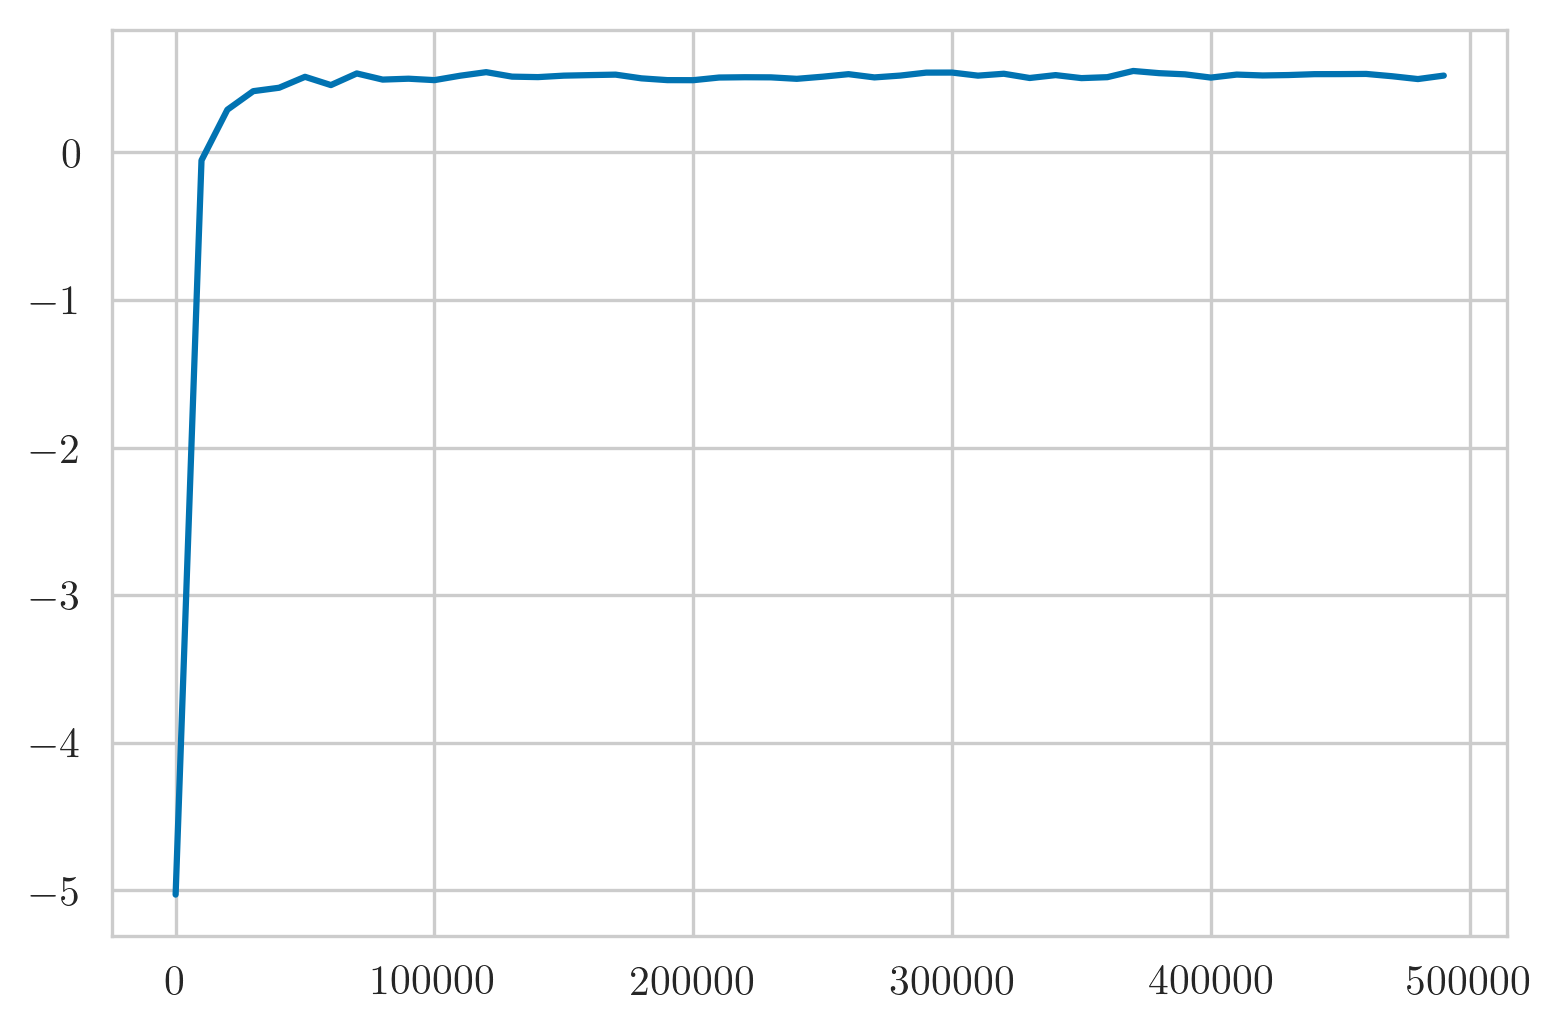

In [63]:
q_learning = Q_learning(env=TicTacToe(), n_episodes=500_000)
q_learning.play_all_episodes()

100%|██████████| 500000/500000 [13:20<00:00, 624.41it/s] 


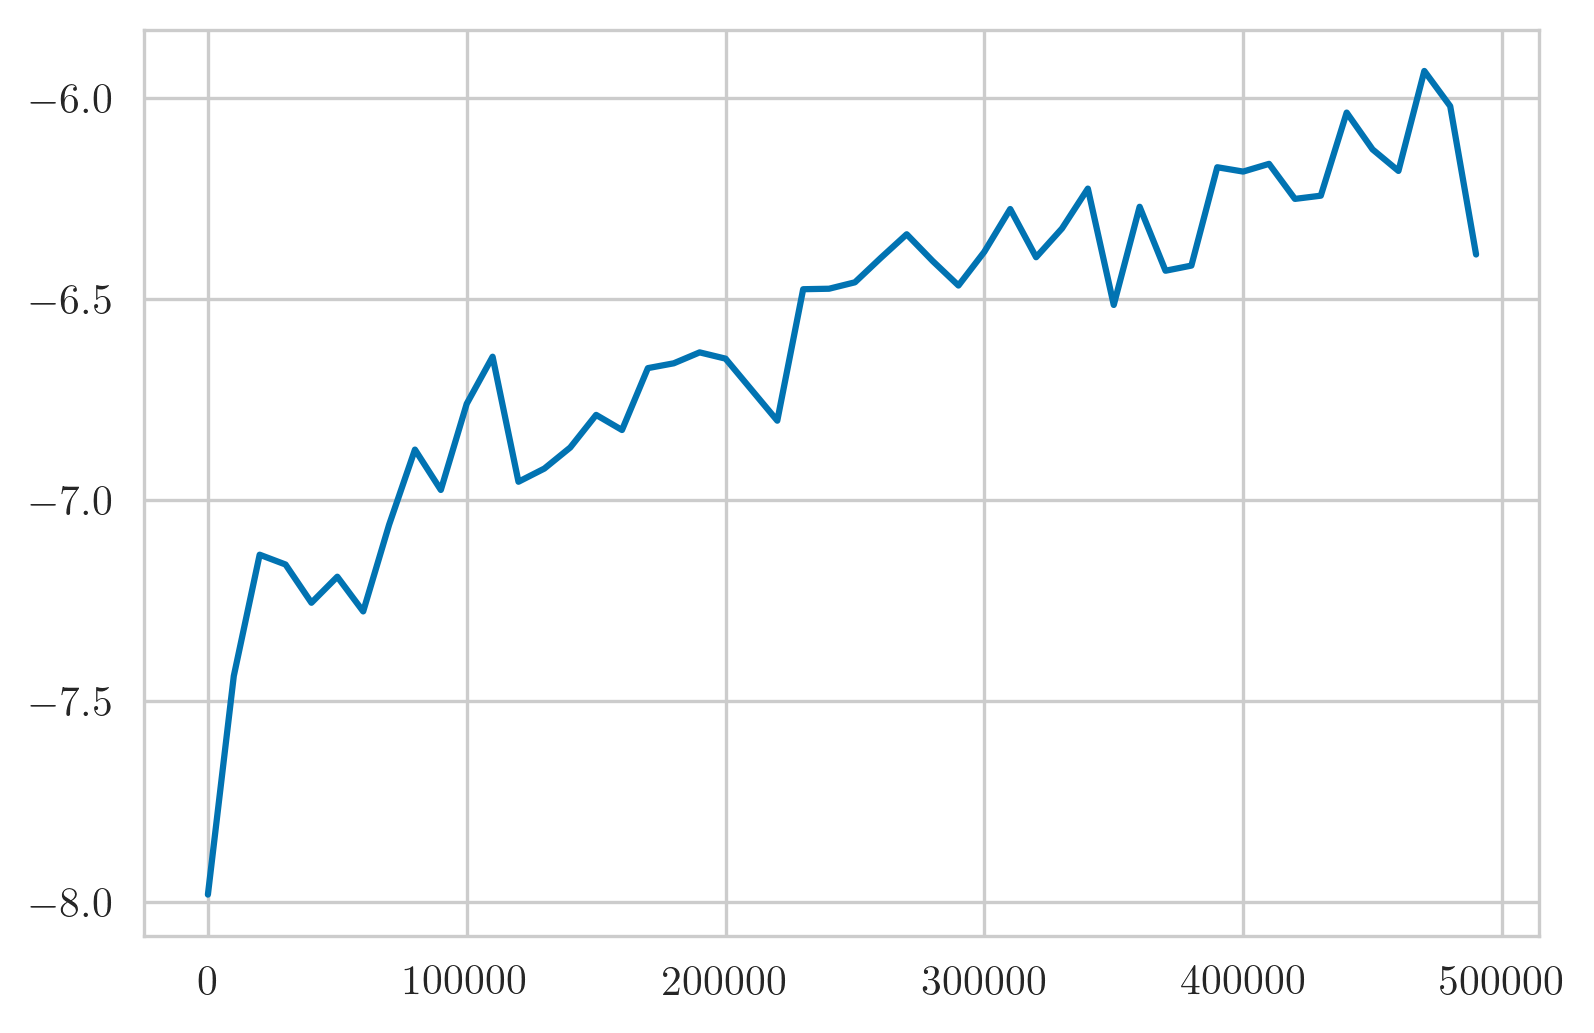

In [64]:
q_learning_big = Q_learning(env=TicTacToe(n_rows=4, n_cols=4, n_win=4), n_episodes=500_000)
q_learning_big.play_all_episodes()

Тут какой-то глюк вычисления. Скорее всего, где-то не поделил что-то, надо разобраться.

## Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

4. Реализуйте Double DQN и/или Dueling DQN.

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [65]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [143]:
from collections import deque
from typing import Optional
# import logging

from gym import make
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch.optim import Adam
from collections import deque
import random
import copy

GAMMA = 0.99
INITIAL_STEPS = 1024
TRANSITIONS = 500_000
STEPS_PER_UPDATE = 4
STEPS_PER_TARGET_UPDATE = STEPS_PER_UPDATE * 1000
BATCH_SIZE = 128
LEARNING_RATE = 5e-4
RANDOM_SEED = 42
BUFFER_SIZE = 10_000

EPS_INIT = 0.95
EPS_FINAL = 0.85

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, field_size=(3, 3), conv_size=3, seed=RANDOM_SEED):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        out_channels_conv = int((field_size[0] + field_size[1] + 2) * 3 / 2)
        hidden_layer_size = out_channels_conv * field_size[0] * field_size[1] * 2
        linear_inc_1 = (1 + field_size[0] - conv_size) * (
            1 + field_size[1] - conv_size
        ) * out_channels_conv

        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,  
                out_channels=out_channels_conv,
                kernel_size=conv_size,
                stride=1,
                padding=0,
            ),
            nn.Sigmoid()
        )
        self.fc1 = nn.Linear(linear_inc_1, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, field_size[0] * field_size[1])

    def forward(self, x):
        """Build a network that maps state -> action values."""
        res = self.conv1(x)
        res = res.reshape(res.size(0), -1)
        res = self.fc1(res)
        res = self.fc2(res)
        return res

In [144]:
def eps_generator(eps_start=1.0, eps_min=0.01, decay_coef=0.9):
    epsilon = eps_start
    yield epsilon
    command = None
    while True:
        if command == "restart":  # Начать сначала
            epsilon = eps_start
            yield epsilon
        else:
            epsilon = max(epsilon*decay_coef, eps_min)  # Новый член последовательности
        command = (yield epsilon)

In [197]:
class TicTacToeDQN():
    def __init__(
        self, 
        n_rows: int = 3, 
        n_cols: int = 3, 
        n_win: int = 3, 
        n_episodes: int = 10_000,
        memory_coef: int = 1000,
    ):
        self.env = TicTacToe(n_rows, n_cols, n_win)
        self.model_x = QNetwork(field_size=(n_rows, n_cols))
        self.model_o = QNetwork(field_size=(n_rows, n_cols))
        self.memory_x = ReplayMemory(memory_coef * n_rows * n_cols)
        self.memory_o = ReplayMemory(memory_coef * n_rows * n_cols)
        self.optimizer_x = Adam(self.model_x.parameters(), LEARNING_RATE)
        self.optimizer_o = Adam(self.model_o.parameters(), LEARNING_RATE)
        
        self.gamma = GAMMA
        self.batch_size = BATCH_SIZE
        
        self.eps_init, self.eps_final = EPS_INIT, EPS_FINAL
        self.eps_threshold = self.eps_init
        self.eps_gen = eps_generator(
            eps_start=self.eps_init, 
            eps_min=self.eps_final, 
            decay_coef=(self.eps_final / self.eps_init) ** (1 / n_episodes),
        )
        self.num_step = 0
        self.n_episodes = n_episodes
        self.quality = []
        self.episode_nums = []
        self.loss_to_learn = F.mse_loss
        
    @staticmethod
    def _random_int_available_action(env):
        return env.int_from_action(random.choice(env.getEmptySpaces()))
        
    def _select_random_action(self):
        return torch.tensor(
            [[self._random_int_available_action(self.env)]], 
            dtype=torch.int64
        )
    
    @staticmethod
    def is_int_action_available(env, i) -> bool:
        action = list(env.action_from_int(i))
        return action in env.getEmptySpaces().tolist()

    def _select_action(self, model, state, greedy: bool = False):
        with torch.no_grad():
            if greedy:
                values = model(
                    state.expand(1, 1, self.env.n_rows, self.env.n_cols)
                )[0].tolist()
                available = [
                    (i, v) for i, v in enumerate(values) if self.is_int_action_available(self.env, i)
                ]
                best_available = list(
                    filter(lambda x: x[1] == max(available, key=lambda x: x[1])[1], available)
                )
                best_action = random.choice(best_available)[0]
                return torch.tensor([[best_action]])
            else:
                sample = random.random()
                self.num_step += 1
                if sample > self.eps_threshold:
                    return self._select_action(model, state, greedy=True)
                else:
                    return self._select_random_action()
    
    def _convert_state_to_tensor(self, env_state):
        state = list(map(int, env_state[0]))
        state_tensor = torch.tensor(
            [state], dtype=torch.float32
        ).reshape(
            self.env.n_rows, self.env.n_cols
        )
        return state_tensor
    
    def _do_step(self, current_state_tensor, greedy: bool = False, random_step: bool = False):
        if self.env.curTurn == 1:
            model = self.model_x
        else:
            model = self.model_o
        if random_step:
            action = self._select_random_action()
        else:
            if greedy:
                action = self._select_action(model, current_state_tensor, greedy)
            else:
                action = self._select_action(model, current_state_tensor)
        new_state, reward, done, _ = self.env.step(
            self.env.action_from_int(action.numpy()[0][0])
        )
        return action, new_state, reward, done
        
    def _run_episode(
        self, 
        do_learning: bool = True, 
        greedy: int = False, 
        vs_random: int = False, 
        side: str = "random"
    ):
        self.model_x.train(False)
        self.model_o.train(False)
        
        self.env.reset()
        state = self.env.getState()
        state_tensor = self._convert_state_to_tensor(state)
        
        if do_learning:
            self.eps_threshold = next(self.eps_gen)
            
        reward_coef = 1
        if side == "o" or (side == "random" and random.random() > 0.5):
            _, state, _, _ = self._do_step(
                state_tensor, 
                greedy=True, 
                random_step=vs_random
            )
            state_tensor = self._convert_state_to_tensor(state)
            reward_coef *= -1
        
        while True:
            action, next_state, reward, done = self._do_step(
                state_tensor, 
                greedy=greedy, 
                random_step=False,
            )
            next_state_tensor = self._convert_state_to_tensor(next_state)
            reward *= reward_coef
                
            if not done:
                action_other, next_state, reward, done = self._do_step(
                    next_state_tensor,
                    greedy=True, 
                    random_step=vs_random
                )
                next_state_tensor = self._convert_state_to_tensor(next_state)
                reward *= reward_coef

            if do_learning:
                transition = (state_tensor, action, next_state_tensor, 
                              torch.tensor([reward], dtype=torch.float32)
                             )
                if reward_coef > 0:
                    self.memory_x.store(transition)
                else:
                    self.memory_o.store(transition)
            state = next_state
            state_tensor = self._convert_state_to_tensor(state)
            
            if do_learning:
                self.learn()
            
            if done:
                break
        return reward
                
    def run(self, vs_random: bool = False):
        self.quality.append(self.mean_reward_vs_random_policy())
        self.episode_nums.append(0)
        for epis in tqdm(range(self.n_episodes)):
            _ = self._run_episode(epis, vs_random=vs_random)
            if (epis + 1) % (self.n_episodes // 50) == 0:
                self.episode_nums.append(epis)
                self.quality.append(
                    self.mean_reward_vs_random_policy())
        self._plot_graph()
    
    def _plot_graph(self):
        plt.plot(self.episode_nums, self.quality)
        plt.show()

    def learn(self):
        if len(self.memory_x) < self.batch_size or len(self.memory_o) < self.batch_size:
            return

        self.model_x.train(True)
        self.model_o.train(True)

        for model, memory, optimizer in [
            (self.model_x, self.memory_x, self.optimizer_x), 
            (self.model_o, self.memory_o, self.optimizer_o)
        ]:

            transitions = memory.sample(self.batch_size)
            batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
            batch_state = Variable(
                torch.cat([
                    state.expand(1, 1, self.env.n_rows, self.env.n_cols) for state in batch_state
                ])
            )
            batch_action = Variable(torch.cat(batch_action))
            batch_reward = Variable(torch.cat(batch_reward))
            batch_next_state = Variable(
                torch.cat([
                    state.expand(1, 1, self.env.n_rows, self.env.n_cols) for state in batch_next_state
                ])
            )

            Q = model(batch_state).gather(1, batch_action).reshape([self.batch_size])

            Qmax = model(batch_next_state).detach().max(1)[0]
            Qnext = batch_reward + (self.gamma * Qmax)

            loss = self.loss_to_learn(Q, Qnext)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def mean_reward_vs_random_policy(self, episodes_to_compare: int = 2_500, side="x"):
        self.model_x.train(False)
        self.model_o.train(False)
        rewards = 0
        for i in range(episodes_to_compare):
            rewards += self._run_episode(
                do_learning=False, 
                greedy=True, 
                vs_random=True, 
                side=side
            )
        return rewards / episodes_to_compare

In [187]:
dqn = TicTacToeDQN(3, 3, 3, 10_000)
dqn.run(vs_random=False)

100%|██████████| 10000/10000 [07:39<00:00, 21.77it/s] 


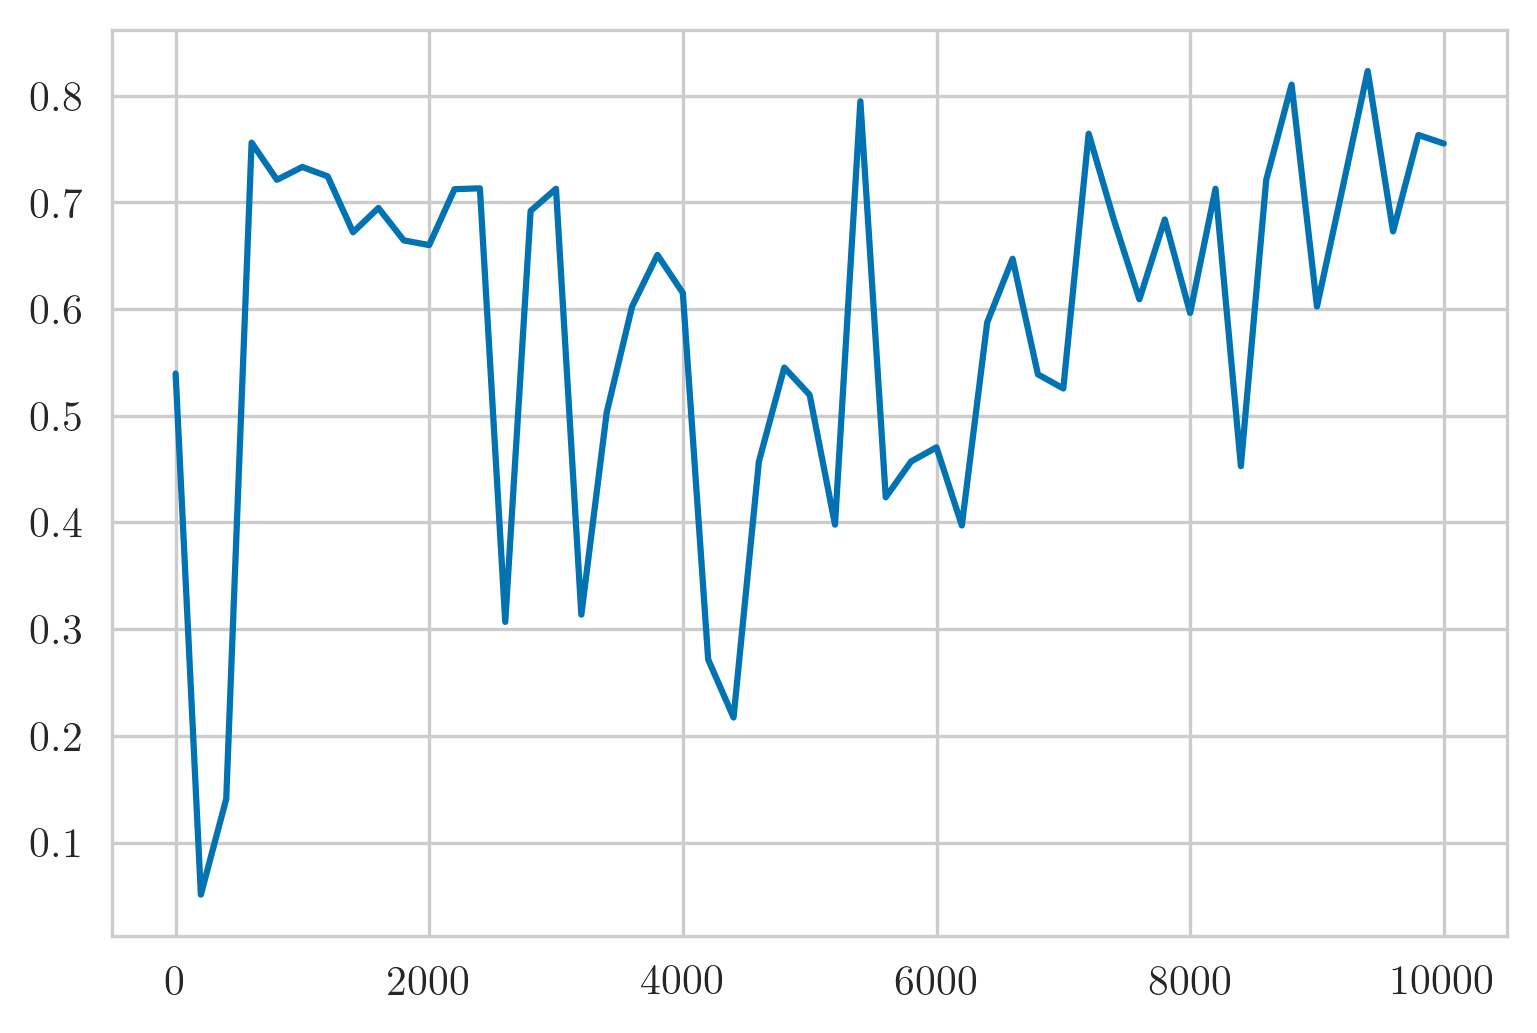

In [195]:
plt.plot(dqn.episode_nums, dqn.quality)
plt.show()

100%|██████████| 10000/10000 [23:16<00:00,  7.16it/s] 


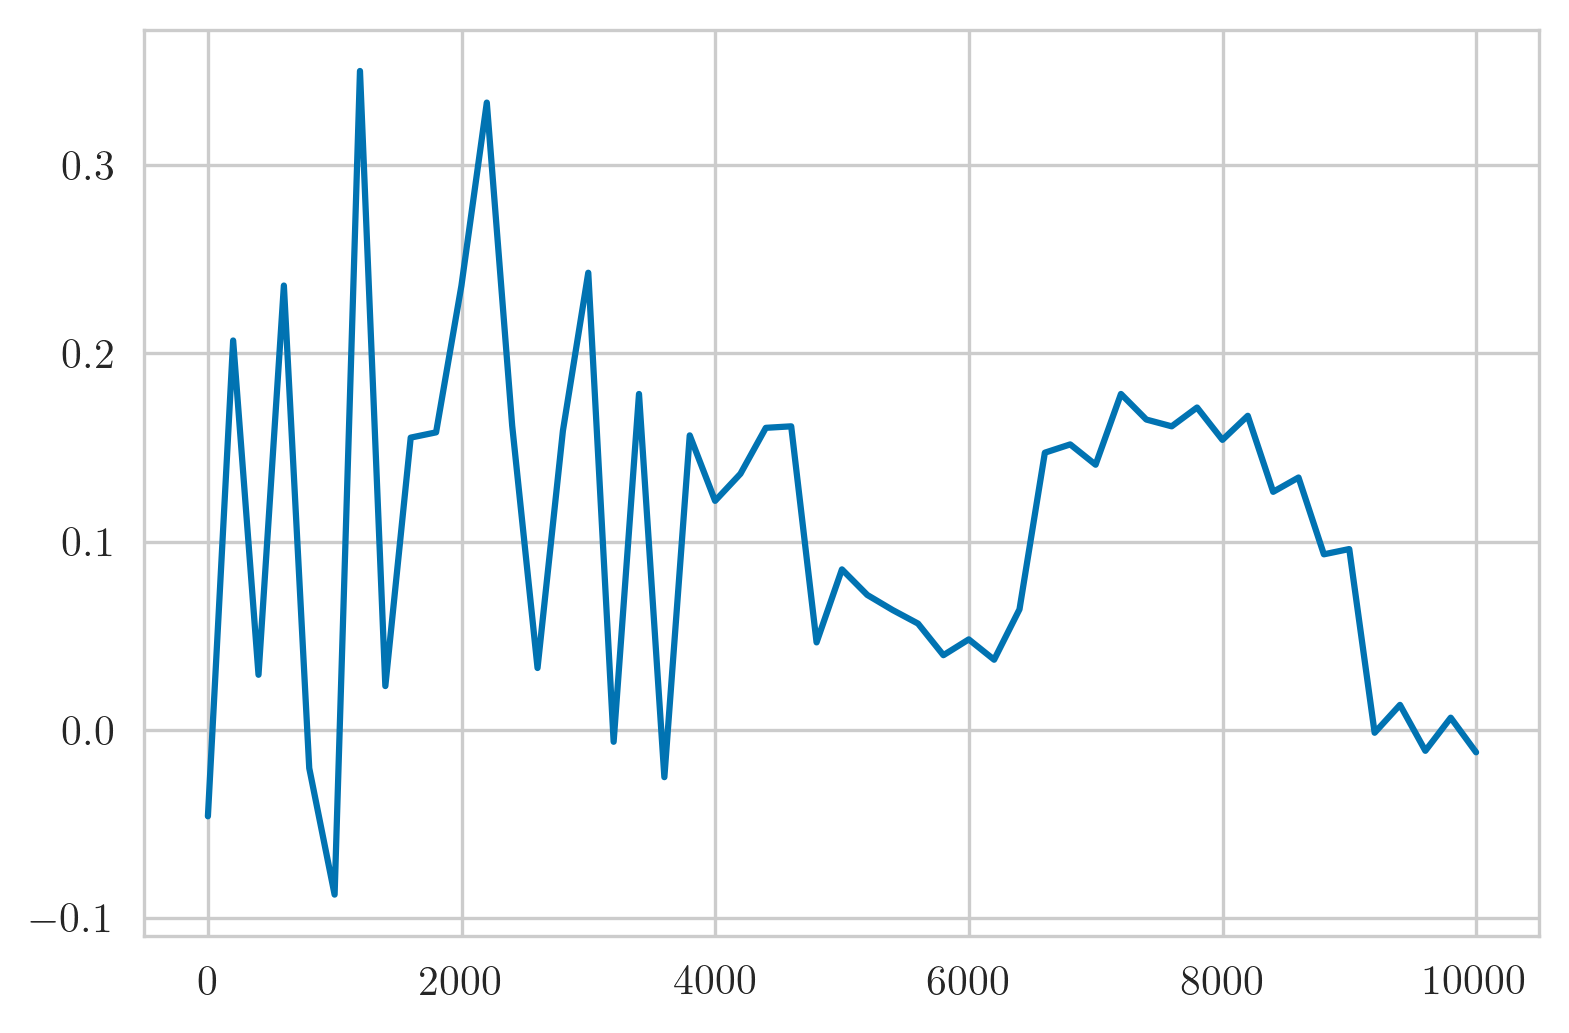

In [198]:
dqn = TicTacToeDQN(4, 4, 4, 10_000)
dqn.run(vs_random=False)

Double DQN

https://towardsdatascience.com/double-deep-q-networks-905dd8325412

In [209]:
class TicTacToeDQNDouble():
    def __init__(
        self, 
        n_rows: int = 3, 
        n_cols: int = 3, 
        n_win: int = 3, 
        n_episodes: int = 10_000,
        memory_coef: int = 1000,
    ):
        self.env = TicTacToe(n_rows, n_cols, n_win)
        self.model_x = [
            QNetwork(field_size=(n_rows, n_cols)), 
            QNetwork(field_size=(n_rows, n_cols))
        ]
        self.model_o = [
            QNetwork(field_size=(n_rows, n_cols)), 
            QNetwork(field_size=(n_rows, n_cols))
        ]
        self.memory_x = ReplayMemory(memory_coef * n_rows * n_cols)
        self.memory_o = ReplayMemory(memory_coef * n_rows * n_cols)
        self.optimizer_x = [
            Adam(self.model_x[0].parameters(), LEARNING_RATE),
            Adam(self.model_x[1].parameters(), LEARNING_RATE)
        ]
        self.optimizer_o = [
            Adam(self.model_o[0].parameters(), LEARNING_RATE),
            Adam(self.model_x[1].parameters(), LEARNING_RATE)
        ]
        
        self.gamma = GAMMA
        self.batch_size = BATCH_SIZE
        
        self.eps_init, self.eps_final = EPS_INIT, EPS_FINAL
        self.eps_threshold = self.eps_init
        self.eps_gen = eps_generator(
            eps_start=self.eps_init, 
            eps_min=self.eps_final, 
            decay_coef=(self.eps_final / self.eps_init) ** (1 / n_episodes),
        )
        self.num_step = 0
        self.n_episodes = n_episodes
        self.quality = []
        self.episode_nums = []
        self.loss_to_learn = F.mse_loss
        
        self.update_count = 0
        
    @staticmethod
    def _random_int_available_action(env):
        return env.int_from_action(random.choice(env.getEmptySpaces()))
        
    def _select_random_action(self):
        return torch.tensor(
            [[self._random_int_available_action(self.env)]], 
            dtype=torch.int64
        )
    
    @staticmethod
    def is_int_action_available(env, i) -> bool:
        action = list(env.action_from_int(i))
        return action in env.getEmptySpaces().tolist()

    def _select_action(self, model, state, greedy: bool = False):
        with torch.no_grad():
            if greedy:
                values = model(
                    state.expand(1, 1, self.env.n_rows, self.env.n_cols)
                )[0].tolist()
                available = [
                    (i, v) for i, v in enumerate(values) if self.is_int_action_available(self.env, i)
                ]
                best_available = list(
                    filter(lambda x: x[1] == max(available, key=lambda x: x[1])[1], available)
                )
                best_action = random.choice(best_available)[0]
                return torch.tensor([[best_action]])
            else:
                sample = random.random()
                self.num_step += 1
                if sample > self.eps_threshold:
                    return self._select_action(model, state, greedy=True)
                else:
                    return self._select_random_action()
    
    def _convert_state_to_tensor(self, env_state):
        state = list(map(int, env_state[0]))
        state_tensor = torch.tensor(
            [state], dtype=torch.float32
        ).reshape(
            self.env.n_rows, self.env.n_cols
        )
        return state_tensor
    
    def _do_step(self, current_state_tensor, greedy: bool = False, random_step: bool = False):
        if self.env.curTurn == 1:
            model = self.model_x[0]
        else:
            model = self.model_o[0]
        if random_step:
            action = self._select_random_action()
        else:
            if greedy:
                action = self._select_action(model, current_state_tensor, greedy)
            else:
                action = self._select_action(model, current_state_tensor)
        new_state, reward, done, _ = self.env.step(
            self.env.action_from_int(action.numpy()[0][0])
        )
        return action, new_state, reward, done
        
    def _run_episode(
        self, 
        do_learning: bool = True, 
        greedy: int = False, 
        vs_random: int = False, 
        side: str = "random"
    ):
        self.model_x[0].train(False)
        self.model_x[1].train(False)
        self.model_o[0].train(False)
        self.model_o[1].train(False)
        
        self.env.reset()
        state = self.env.getState()
        state_tensor = self._convert_state_to_tensor(state)
        
        if do_learning:
            self.eps_threshold = next(self.eps_gen)
            
        reward_coef = 1
        if side == "o" or (side == "random" and random.random() > 0.5):
            _, state, _, _ = self._do_step(
                state_tensor, 
                greedy=True, 
                random_step=vs_random
            )
            state_tensor = self._convert_state_to_tensor(state)
            reward_coef *= -1
        
        while True:
            action, next_state, reward, done = self._do_step(
                state_tensor, 
                greedy=greedy, 
                random_step=False,
            )
            next_state_tensor = self._convert_state_to_tensor(next_state)
            reward *= reward_coef
                
            if not done:
                action_other, next_state, reward, done = self._do_step(
                    next_state_tensor,
                    greedy=True, 
                    random_step=vs_random
                )
                next_state_tensor = self._convert_state_to_tensor(next_state)
                reward *= reward_coef

            if do_learning:
                transition = (state_tensor, action, next_state_tensor, 
                              torch.tensor([reward], dtype=torch.float32)
                             )
                if reward_coef > 0:
                    self.memory_x.store(transition)
                else:
                    self.memory_o.store(transition)
            state = next_state
            state_tensor = self._convert_state_to_tensor(state)
            
            if do_learning:
                self.learn()
            
            if done:
                break
        return reward
                
    def run(self, vs_random: bool = False):
        self.quality.append(self.mean_reward_vs_random_policy())
        self.episode_nums.append(0)
        for epis in tqdm(range(self.n_episodes)):
            _ = self._run_episode(epis, vs_random=vs_random)
            if (epis + 1) % (self.n_episodes // 50) == 0:
                self.episode_nums.append(epis)
                self.quality.append(
                    self.mean_reward_vs_random_policy())
        self._plot_graph()
        
    def _update_target_network(self):
        self.update_count += 1
        if self.update_count % 5 == 0:
            self.model_x[1].load_state_dict(
                self.model_x[0].state_dict()
            )
    
    def _plot_graph(self):
        plt.plot(self.episode_nums, self.quality)
        plt.show()

    def learn(self):
        if len(self.memory_x) < self.batch_size or len(self.memory_o) < self.batch_size:
            return

        self.model_x[0].train(True)
        self.model_o[0].train(True)
        self.model_x[1].train(True)
        self.model_o[1].train(True)

        for model, memory, optimizer in [
            (self.model_x, self.memory_x, self.optimizer_x), 
            (self.model_o, self.memory_o, self.optimizer_o)
        ]:

            transitions = memory.sample(self.batch_size)
            batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
            batch_state = Variable(
                torch.cat([
                    state.expand(1, 1, self.env.n_rows, self.env.n_cols) for state in batch_state
                ])
            )
            batch_action = Variable(torch.cat(batch_action))
            batch_reward = Variable(torch.cat(batch_reward))
            batch_next_state = Variable(
                torch.cat([
                    state.expand(1, 1, self.env.n_rows, self.env.n_cols) for state in batch_next_state
                ])
            )

            Q = model[0](batch_state).gather(1, batch_action).reshape([self.batch_size])

            Qmax = model[0](batch_next_state).detach()[
                :, torch.argmax(model[1](batch_next_state).detach(), 1)
            ][: ,0]
            Qnext = batch_reward + (self.gamma * Qmax)

            loss = self.loss_to_learn(Q, Qnext)

            optimizer[0].zero_grad()
            loss.backward()
            optimizer[0].step()
            
            self._update_target_network()

    def mean_reward_vs_random_policy(self, episodes_to_compare: int = 2_500, side="x"):
        self.model_x[0].train(False)
        self.model_x[1].train(False)
        self.model_o[0].train(False)
        self.model_o[1].train(False)
        rewards = 0
        for i in range(episodes_to_compare):
            rewards += self._run_episode(
                do_learning=False, 
                greedy=True, 
                vs_random=True, 
                side=side
            )
        return rewards / episodes_to_compare

100%|██████████| 10000/10000 [08:05<00:00, 20.61it/s] 


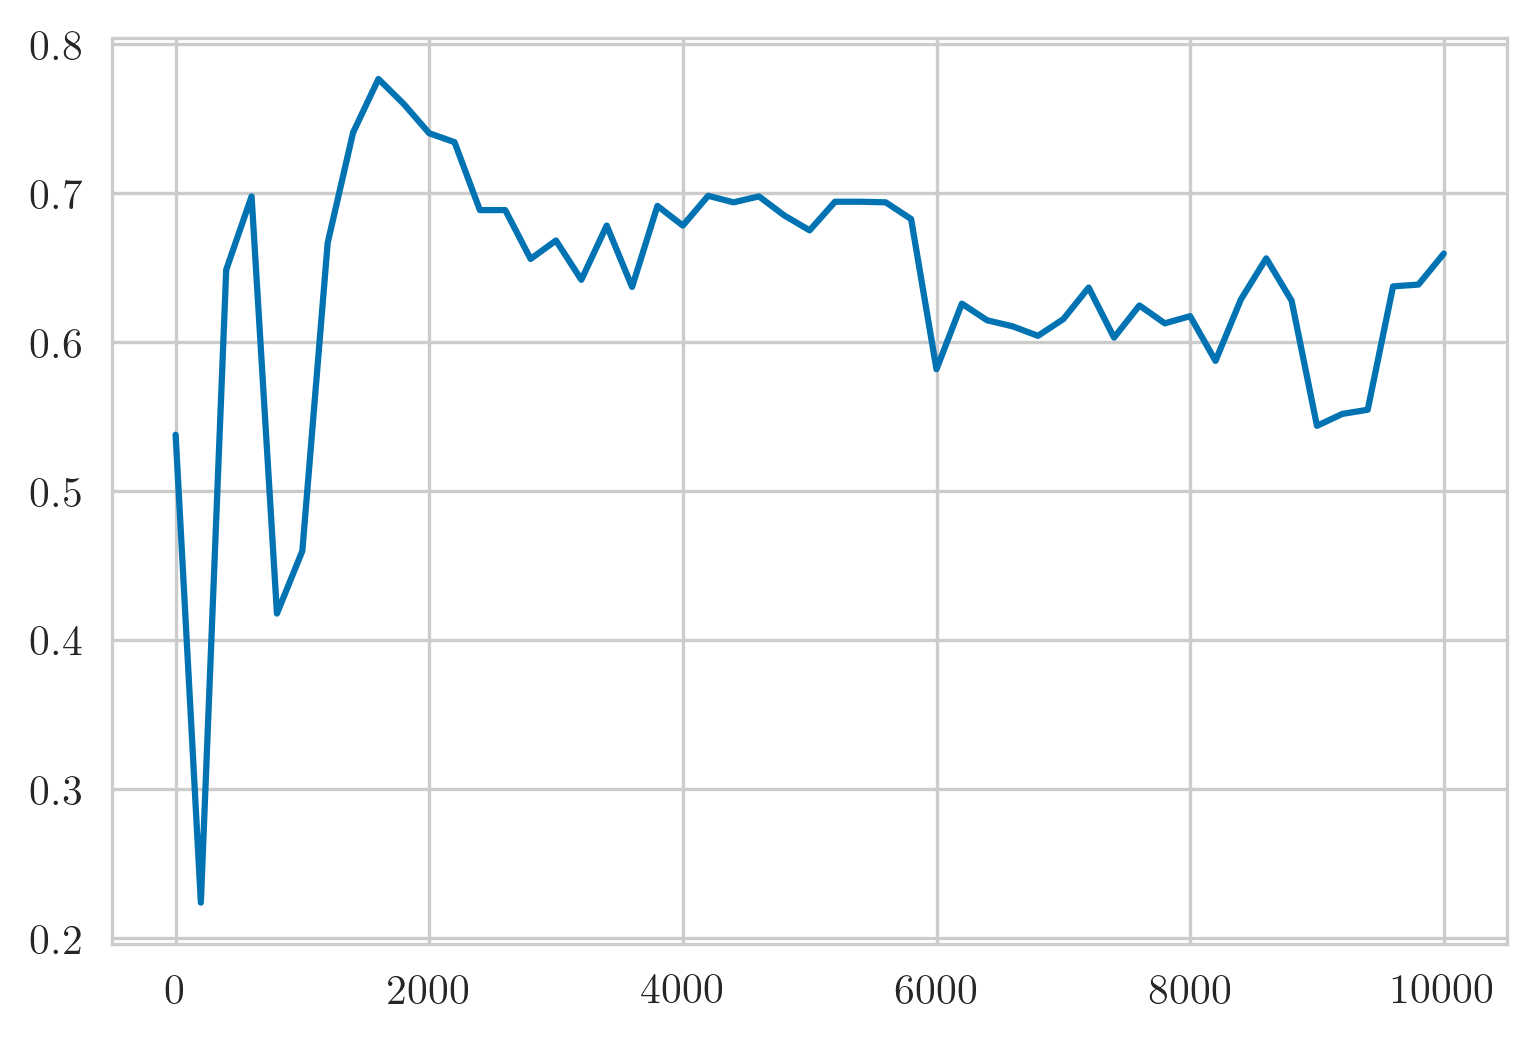

In [210]:
dqn = TicTacToeDQNDouble(3, 3, 3, 10_000)
dqn.run(vs_random=False)

100%|██████████| 20000/20000 [28:04<00:00, 11.88it/s]  


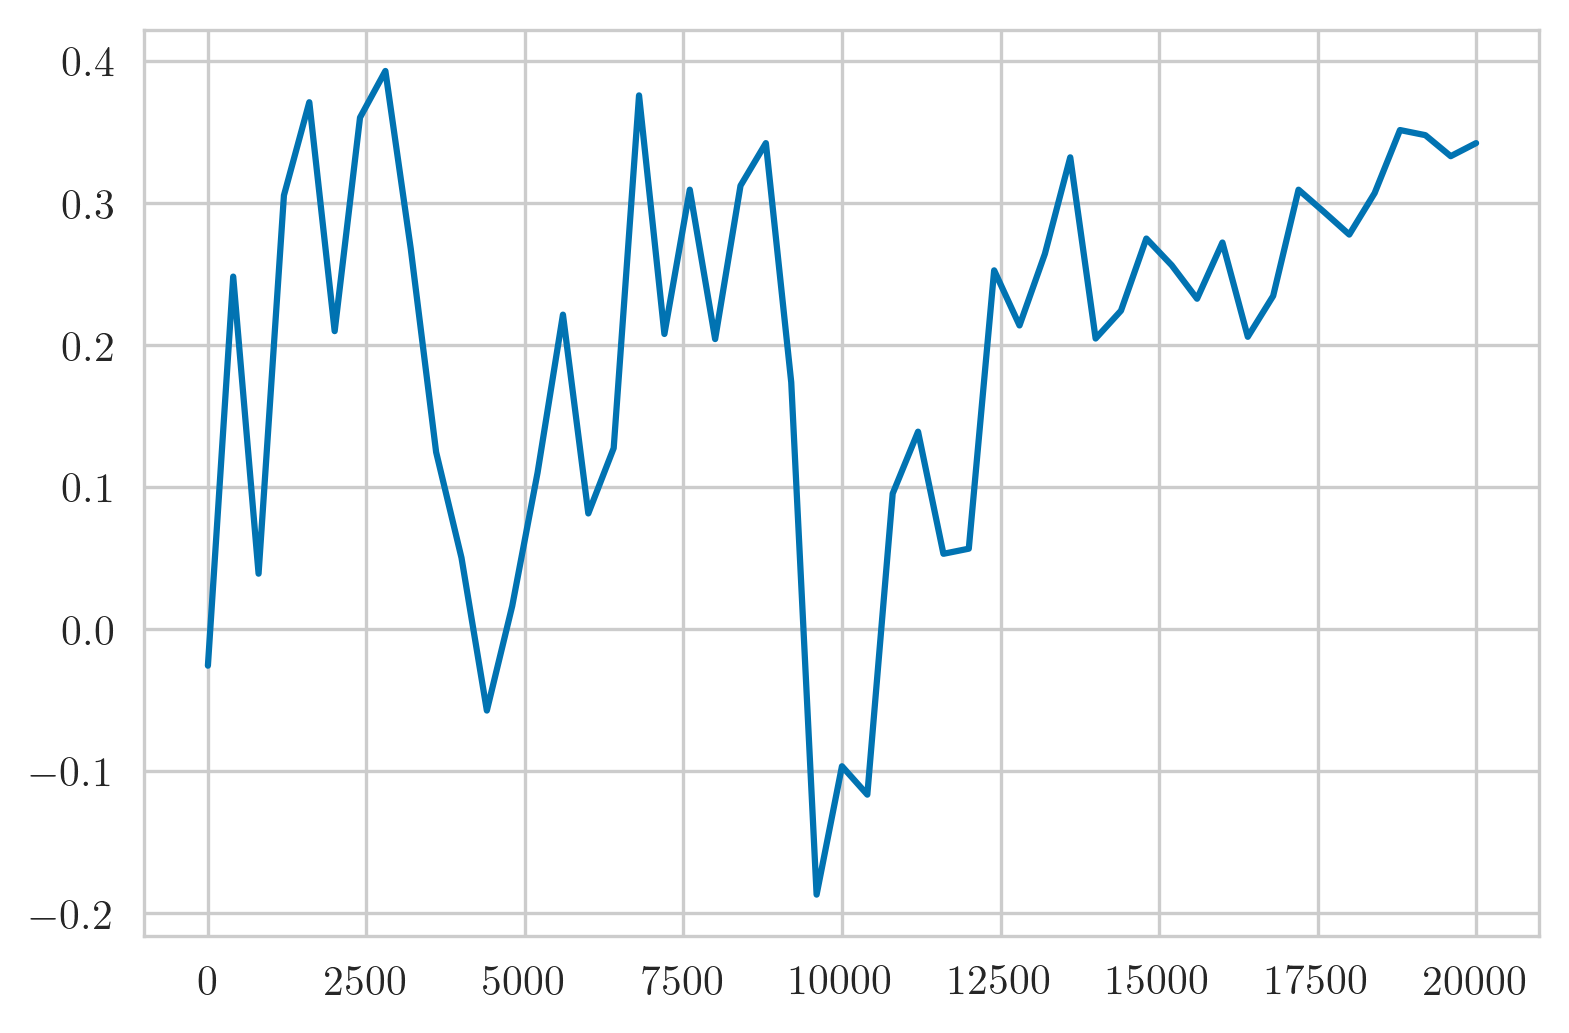

In [212]:
dqn = TicTacToeDQNDouble(4, 4, 4, 20_000)
dqn.run(vs_random=False)

Видно, что для бОльшего поля для лучшего качества нужно больше итераций обучения (+ вероятно, усреденение по бОльшему числу итераций)

## Часть третья: расширим и углубим поиск

Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.

5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

## Часть четвёртая, опциональная: AlphaZero

В опциональной части домашнего задания давайте попробуем всё-таки собрать всё вместе и завести настоящий AlphaZero. Если получится и будет обобщаться на большие доски, будет очень круто и будет стоить много дополнительных баллов.

7. Реализуйте AlphaZero для крестиков-ноликов, используя MCTS из третьей части и DQN-сеть из второй части. Обучите стратегии для игры на больших досках (10х10 и выше, до пяти в ряд; опять же, может потребовать много времени, так что достаточно показать, что обучение началось и идёт).